# 0. Setup

In [3]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')



In [4]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))



In [5]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 1729)

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


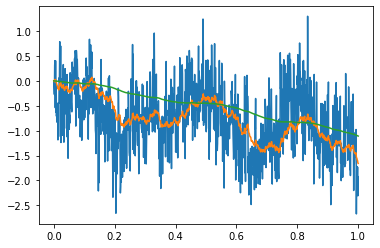

In [6]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

# 1. MLE

In [7]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 
    n_steps = x.shape[0]
    
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = diffs = x[1:] - x[:-1]

    return np.log(np.dot(diffs, diffs)) / np.log(T / n_steps)


def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 
    


def max_MLE(x, T):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        scalar = (T / n_steps) ** (2 * H_hat)
        R_inv = np.linalg.inv(R) / scalar
        sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        return H_hat, sigma_hat

    return H.success

In [8]:
# Check this code works for a selection of cases

test_vals = np.arange(0.05, 0.9, 0.05)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    print(i_val)
    for j, j_val in enumerate(test_scalars):
        print(j_val)
        test_sim = simulate_fbm(1, 1024, 1, i_val)
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val
    

0.05
0.5
1.0
1.5
0.1
0.5
1.0
1.5
0.15000000000000002
0.5
1.0
1.5
0.2
0.5


In [ ]:
val_errors

array([[-0.00017247,  0.00416161,  0.00093304],
       [ 0.00456824, -0.00075299,  0.00200584],
       [-0.00347826, -0.0080004 ,  0.00237534],
       [ 0.00555242,  0.01206107, -0.00650364],
       [-0.00568874, -0.00429924,  0.0041356 ],
       [ 0.01215804, -0.01280864, -0.01542132],
       [-0.01754212, -0.00063656,  0.01066146],
       [-0.00229934,  0.00211435,  0.00479308],
       [ 0.00391767, -0.00249409, -0.00365476],
       [-0.0082923 ,  0.01146973, -0.006367  ]])

In [ ]:
scalar_errors

array([[ 0.00173049, -0.01217962,  0.03003805],
       [ 0.03096729, -0.02388831,  0.02914784],
       [-0.00310076, -0.02698139, -0.00989755],
       [ 0.02208547,  0.04832584, -0.07381774],
       [-0.00618133,  0.00343923,  0.0460405 ],
       [ 0.02495138, -0.07195296, -0.12849664],
       [-0.02803815, -0.02416775,  0.0970661 ],
       [ 0.00781653, -0.02101344,  0.01143755],
       [ 0.01259572, -0.02220566, -0.10206368],
       [-0.03001202,  0.08857268, -0.03025592]])

In [ ]:
sample_fbm = np.loadtxt('C:\\Users\\jamma\\Masters\\Dissertation\\fBMPath2.txt')
sample_fbm.shape[0]

NameError: name 'np' is not defined

In [ ]:
sample_fbm = np.loadtxt('C:\\Users\jamma\Masters\Dissertation\\fBMPath2.txt')
sample_fbm.shape[0]

1024

In [ ]:
max_MLE(sample_fbm, 1)


(array([0.03567489]), 1.159694536152918)

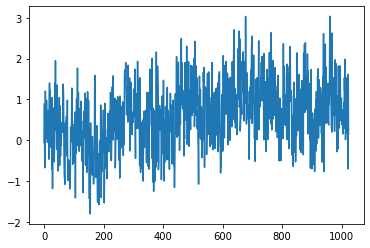

In [ ]:
plt.plot(sample_fbm)

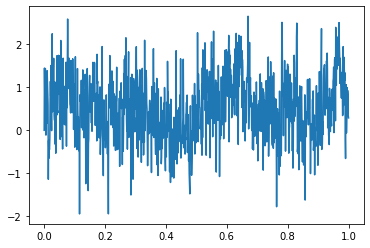

In [ ]:
out = simulate_fbm(1, 1024, 1, 0.03567489)
plt.plot(span, out.T * 1.1596978410643428)